## Demo: Stage3 - Combine individual instruments to one xarray dataset

Here we want to treat one mooring as one dataset.

The time sampling differs between instruments -- for the *first guess* (24 Aug 2025) we will use a simple interpolation onto a common grid.



In [121]:
import os

import yaml
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
from ctd_tools.writers import NetCdfWriter

from oceanarray import tools

moorlist = ['ds2_X_2012','ds2_X_2017','ds2_X_2018',
            'ds8_1_2012','ds9_1_2012','ds10_1_2012', 'ds11_1_2012','ds12_1_2012',
            'ds13_1_2012','ds14_1_2012','ds15_1_2012','ds16_1_2012','ds17_1_2012',
            'ds19_1_2012','ds18_1_2012','ds28_1_2017',
            'dsA_1_2018','dsB_1_2018','dsC_1_2018', 'dsD_1_2018','dsE_1_2018','dsF_1_2018',
            'dsM1_1_2017','dsM2_1_2017','dsM3_1_2017','dsM4_1_2017','dsM5_1_2017']
moorlist = ['dsE_1_2018']

## Load data for one mooring into datasets, list of xarray datasets

In [122]:
# Specify the base directory.  raw is a subdirectory from here moor/raw/ and proc is moor/proc
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
output_path = basedir + 'moor/proc/'

# Toggle to load the *_raw.nc or the *_use.nc
file_subscript = '_use'
print(f"Using files with {file_subscript}")



# Cycle through the yaml and load instrument data into a list of xarray datasets
# Enrich the netCDF with information from the yaml file
# Find the mooring's processed directory & read the yaml specification
name1 = moorlist[0]
proc_dir = output_path + name1
moor_yaml = proc_dir + '/' + name1 + '.mooring.yaml'
with open(moor_yaml, 'r') as f:
    moor_yaml_data = yaml.safe_load(f)

# For each instrument, load the raw netCDF files and add some metadata from the yaml
datasets = []
for i in moor_yaml_data['instruments']:
    fname = name1 + '_' + str(i['serial']) + file_subscript + '.nc'
    usefile = proc_dir + '/' + i['instrument'] + '/' + fname

    if os.path.exists(usefile):
        print(usefile)
        ds1 = xr.open_dataset(usefile)

        if 'InstrDepth' not in ds1.variables and 'depth' in i:
            ds1['InstrDepth'] = i['depth']
        if 'instrument' not in ds1.variables and 'instrument' in i:
            ds1['instrument'] = i['instrument']
        if 'serial_number' not in ds1.variables and 'serial' in i:
            ds1['serial_number'] = i['serial']
        if 'timeS' in ds1.variables:
            ds1 = ds1.drop_vars('timeS')
        #---------------------------------------------
        # Store the data in a list of datasets
        datasets.append(ds1)




Using files with _use
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_use.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_use.

In [123]:
# Collect some timing info for each instrument
intervals_min = []
start_times = []
end_times = []
# For each dataset, write the coverage
for idx, ds in enumerate(datasets):
    time = ds['time']
    start_time = str(time.values[0])
    end_time = str(time.values[-1])
    time_interval = (time.values[1] - time.values[0]) / np.timedelta64(1, 'm')
    time_interval = np.nanmedian(np.diff(time.values) / np.timedelta64(1, 'm') )
    if time_interval > 1:
        tstr = f"{time_interval:1.2f} min"
    else:
        tstr = f"{time_interval * 60:1.2f} sec"
    variables = list(ds.data_vars)
    print(f"Dataset {idx} depth {str(ds['InstrDepth'].values)} [{ds['instrument'].values}:{ds['serial_number'].values}]:")
    print(f"  Start time: {start_time[0:19]}.  End time:   {end_time[0:19]}.  Time interval: {tstr}")
    print(f"  Coordinates: {list(ds.coords)}.  Variables: {variables}")

    #---------------------------------------------
    # Save the interval for later use
    intervals_min.append(time_interval)
    start_times.append(time.values[0])
    end_times.append(time.values[-1])

earliest_start = min(start_times)
latest_end = max(end_times)
time_grid = np.arange(earliest_start, latest_end, np.timedelta64(int(np.nanmedian(intervals_min) * 60), 's'))

print(f"Time grid length: {len(time_grid)}")
print(f"First time: {time_grid[0]}")
print(f"Last time: {time_grid[-1]}")

Dataset 0 depth 629 [sbe56:6363]:
  Start time: 2018-08-13T12:00:00.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 1 depth 679 [sbe16:2419]:
  Start time: 2018-08-15T11:56:41.  End time:   2018-08-26T10:37:41.  Time interval: 20.00 sec
  Coordinates: ['time'].  Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
Dataset 2 depth 689 [sbe56:6401]:
  Start time: 2018-08-13T11:20:00.  End time:   2018-08-26T10:37:59.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 3 depth 699 [sbe56:6402]:
  Start time: 2018-08-13T12:15:50.  End time:   2018-08-26T10:37:59.  Time in

# Interpolate dataset

Here we interpolate data onto the same time grid to simply checking for clock offsets (in a later step)

In [124]:
with xr.set_options(keep_attrs=True):
    datasets_interp = []
    for idx, ds in enumerate(datasets):
        if 'time' not in ds.sizes or ds.sizes['time'] <= 1:
            continue

        # interpolate the whole dataset at once
        ds_i = ds.interp(time=time_grid)

        # preserve global attrs (Dataset.interp can drop them)
        ds_i.attrs = dict(ds.attrs)

        # keep coord attrs too (optional)
        if 'time' in ds.coords and ds.time.attrs:
            ds_i.time.attrs = dict(ds.time.attrs)

        # add any extra coords you want to carry through
        if 'InstrDepth' in ds:
            ds_i = ds_i.assign_coords(InstrDepth=ds['InstrDepth'])
        if 'clock_offset' in ds:
            ds_i = ds_i.assign_coords(clock_offset=ds['clock_offset'])

        datasets_interp.append(ds_i)


In [125]:


import xarray as xr

def merge_global_attrs(ds_list, *, order="last"):
    """
    Union of all global attrs across datasets.
    If the same key appears multiple times, later datasets overwrite earlier ones (order='last').
    Use order='first' to prefer the first occurrence instead.
    """
    merged = {}
    if order == "last":
        it = ds_list
    else:  # 'first'
        it = reversed(ds_list)
    for ds in it:
        if hasattr(ds, "attrs") and ds.attrs:
            merged.update(dict(ds.attrs))  # later updates overwrite
    return merged

def merge_var_attrs(varname, ds_list, *, order="last"):
    """
    Union of attrs for a given variable across datasets in ds_list.
    Later datasets overwrite earlier ones (order='last').
    """
    merged = {}
    if order == "last":
        it = ds_list
    else:
        it = reversed(ds_list)
    for ds in it:
        if varname in ds and getattr(ds[varname], "attrs", None):
            merged.update(dict(ds[varname].attrs))
    return merged

def copy_coord_attrs(src_ds: xr.Dataset, dst_ds: xr.Dataset, coord_names=("time",)):
    """Copy attrs for specific coords from src to dst if present."""
    for c in coord_names:
        if c in src_ds.coords and getattr(src_ds[c], "attrs", None):
            dst_ds[c].attrs = dict(src_ds[c].attrs)


#combined_ds.attrs = common_attrs(datasets_clean)
# Optionally carry time attrs
#if 'time' in datasets_interp[0].coords and datasets_interp[0].time.attrs:
#    combined_ds['time'].attrs = dict(datasets_interp[0].time.attrs)
#combined_ds.attrs =


# Combine interpolated datasets

In [126]:
# List of variables to keep
vars_to_keep = ['temperature', 'salinity', 'conductivity', 'pressure', 'u_velocity','v_velocity']#,'serial_number','InstrDepth']

# Remove unwanted variables from each dataset
datasets_clean = []
for ds in datasets_interp:
    ds_sel = ds.drop_vars(['density', 'potential_temperature', 'julian_days_offset','timeS'], errors='ignore')
    datasets_clean.append(ds_sel)

# Find union of all time coordinates (should be the same for all, but let's check)
time_coord = datasets_interp[0]['time']

# Prepare data arrays for each variable
combined_data = {}
N_LEVELS = len(datasets_clean)

def first_ds_with(var):
    for d in datasets_clean:
        if var in d:
            return d[var]
    return None
def stacked_or_nan(var):
    arrs = []
    for ds in datasets_clean:
        if var in ds:
            arrs.append(ds[var].values)
        else:
            arrs.append(np.full(time_coord.shape, np.nan, dtype=float))
    return np.stack(arrs, axis=-1)  # (time, N_LEVELS)

for var in vars_to_keep:
    stacked = stacked_or_nan(var)
    var_attrs = merge_var_attrs(var, datasets_clean, order="last")
    combined_data[var] = xr.DataArray(
        stacked,
        dims=('time','N_LEVELS'),
        coords={'time': time_coord, 'N_LEVELS': np.arange(N_LEVELS)},
        attrs=var_attrs
    )


# Per-level metadata coords
depths, clock_offsets, serial, instrtype = [], [], [], []
for ds in datasets_clean:
    depths.append(float(ds['InstrDepth'].item()) if 'InstrDepth' in ds else np.nan)
    serial.append(ds['serial_number'].item() if 'serial_number' in ds else np.nan)
    instrtype.append(ds['instrument'].item() if 'instrument' in ds else 'unknown')
    if 'clock_offset' in ds:
        co = ds['clock_offset'].item()
    elif 'seconds_offset' in ds:
        co = ds['seconds_offset'].item()
    else:
        co = 0
    clock_offsets.append(int(np.rint(co)) if np.isfinite(co) else 0)

combined_ds = xr.Dataset(
    data_vars=combined_data,
    coords={
        'time': time_coord,
        'N_LEVELS': np.arange(N_LEVELS),
        'clock_offset': ('N_LEVELS', np.asarray(clock_offsets)),
        'serial_number': ('N_LEVELS', np.asarray(serial)),
        'nominal_depth': ('N_LEVELS', np.asarray(depths)),
        'instrument': ('N_LEVELS', np.asarray(instrtype)),
    }
)

# Apply merged GLOBAL attrs (union across all inputs, last dataset wins on conflicts)
combined_ds.attrs = merge_global_attrs(datasets_clean, order="last")

# Optionally also copy coordinate attrs (e.g., 'time' units, calendar)
copy_coord_attrs(datasets_interp[0], combined_ds, coord_names=("time",))


In [127]:
import numpy as np
import xarray as xr

def encode_instrument_as_flags(ds: xr.Dataset,
                               var_name: str = "instrument",
                               out_name: str = "instrument_id") -> xr.Dataset:
    if var_name not in ds:
        return ds

    names = [str(v) for v in np.asarray(ds[var_name].values)]
    uniq = []
    for n in names:
        if n not in uniq:
            uniq.append(n)
    codes = {name: i+1 for i, name in enumerate(uniq)}  # start at 1
    id_arr = np.array([codes[n] for n in names], dtype=np.int16)

    ds = ds.copy()
    ds[out_name] = (("N_LEVELS",), id_arr)
    # CF style metadata
    ds[out_name].attrs.update({
        "standard_name": "instrument_id",
        "long_name": "Instrument identifier (encoded)",
        "flag_values": np.array(list(range(1, len(uniq)+1)), dtype=np.int16),
        "flag_meanings": " ".join(s.replace(" ", "_") for s in uniq),
        "comment": f"Mapping: {codes}"
    })

    # Optional: keep a readable list at global attrs
    ds.attrs["instrument_names"] = ", ".join(uniq)

    # Drop the string variable so writers don’t touch it
    ds = ds.drop_vars(var_name)

    return ds


In [128]:
fname = name1 + '_mooring'  + file_subscript + '.nc'
usefile = proc_dir + '/' + fname
ds_to_save = encode_instrument_as_flags(combined_ds)

print(usefile)
if 1:
    writer = NetCdfWriter(ds_to_save)
    writer.write(
        usefile,
        optimize=True,
        drop_derived=False,  # drops vars with attrs["derived"] == True (e.g., z)
        uint8_vars=[
            "correlation_magnitude", "echo_intensity", "status", "percent_good",
            "bt_correlation", "bt_amplitude", "bt_percent_good",
        ],
        float32_vars=[  # optional explicit list; float32=True already covers floats generically
            "eastward_velocity", "northward_velocity", "upward_velocity",
            "temperature", "salinity", "pressure", "pressure_std", "depth", "bt_velocity",
        ],
        chunk_time=3600,  # 1-hour chunks if you have ~1 Hz ensembles; adjust as needed
        complevel=5,
        quantize=3,
    )


/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/dsE_1_2018_mooring_use.nc


/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:97: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(max(1, min(ds.dims[d], int(chunk_time))))
/Users/eddifying/Cloudfree/gitlab-cloudfree/ctd-tools/ctd_tools/writers/netcdf_writer.py:100: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chunks.append(ds.dims[d])


In [129]:
combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    latitude       float32 4B ...
    longitude      float32 4B ...
    InstrDepth     int64 8B 629
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
Attributes: (12/32)
    latitude:                     nan
    longitude:                    nan
    CreateTime:                   2025-07-27T02:20:32
    DataType:                     TimeSeries
    processor_input_file_type:    
    mooring_name:                 dsE_1_2018
    ...                           ...
    history:                      2025-08-24T18:23:38Z: created from <functio...
    processor_name:               ctd_tools
    processor_version:            0.2.0
    processor_reader_class:       RbrRskLegacyReader
    processor_python_version:     3.11.7
    processor_input_filename:     /Users/eddifying/Dropbox/data/ifmro_mixsed/...

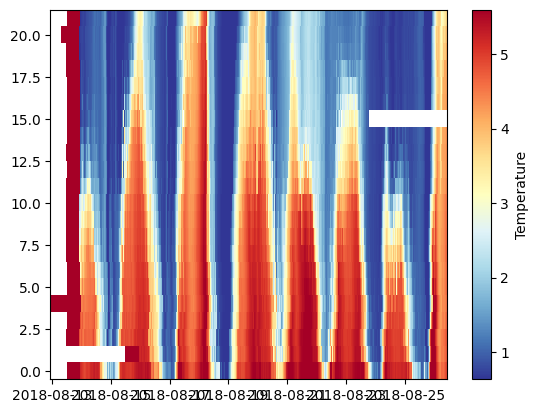

In [130]:
plt.pcolormesh(combined_ds.time,combined_ds.N_LEVELS,combined_ds.temperature.transpose(), cmap='RdYlBu_r')
vmin = np.nanpercentile(combined_ds.temperature.values, 5)
vmax = np.nanpercentile(combined_ds.temperature.values, 95)
plt.clim(vmin, vmax)
plt.colorbar(label='Temperature')

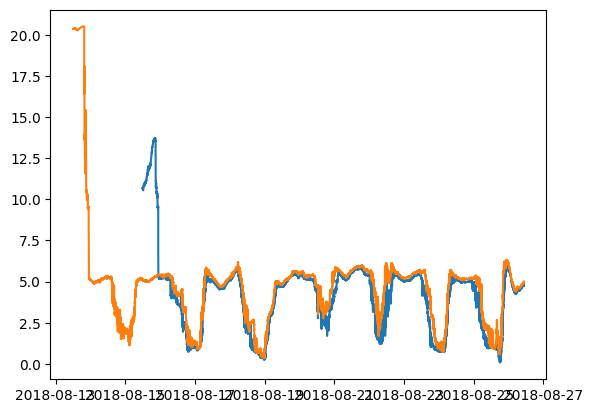

In [131]:
# Now average the temperature in time using a median average
plt.plot(combined_ds.time,combined_ds.temperature[:,1])
plt.plot(combined_ds.time,combined_ds.temperature[:,0])

In [132]:
combined_ds

<xarray.Dataset> Size: 124MB
Dimensions:        (time: 116604, N_LEVELS: 22)
Coordinates:
  * time           (time) datetime64[ns] 933kB 2018-08-12T22:44:08.979200 ......
  * N_LEVELS       (N_LEVELS) int64 176B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
    latitude       float32 4B ...
    longitude      float32 4B ...
    InstrDepth     int64 8B 629
    clock_offset   (N_LEVELS) int64 176B 0 259000 -2400 950 ... 84420 -2050 -200
    serial_number  (N_LEVELS) int64 176B 6363 2419 6401 6402 ... 15577 7518 6364
    nominal_depth  (N_LEVELS) float64 176B 629.0 679.0 689.0 ... 880.0 905.0
    instrument     (N_LEVELS) <U8 704B 'sbe56' 'sbe16' ... 'microcat' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 21MB nan nan nan ... 4.033 nan 3.78
    salinity       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 21MB nan nan nan nan ... nan nan nan
Attributes: (12/32)
    latitude:                     nan
    longitude:                    nan
    CreateTime:                   2025-07-27T02:20:32
    DataType:                     TimeSeries
    processor_input_file_type:    
    mooring_name:                 dsE_1_2018
    ...                           ...
    history:                      2025-08-24T18:23:38Z: created from <functio...
    processor_name:               ctd_tools
    processor_version:            0.2.0
    processor_reader_class:       RbrRskLegacyReader
    processor_python_version:     3.11.7
    processor_input_filename:     /Users/eddifying/Dropbox/data/ifmro_mixsed/...